In [1]:
%load_ext autoreload
%autoreload 2
import tensorflow as tf
import zarr
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from spliceai.utils import one_hot_encode
from pyfaidx import Fasta
from Bio.Seq import reverse_complement
import os
os.chdir("/zata/zippy/ramirezc/splice-model-benchmark")

# from gopher import saliency_embed
# from gopher import utils

2025-04-30 22:33:50.954301: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746066830.979620 2595898 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746066830.993467 2595898 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746066831.031358 2595898 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746066831.031392 2595898 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746066831.031397 2595898 computation_placer.cc:177] computation placer alr

In [ ]:
# 1. Load your model
weights_path = "reference_files/spliceai/models/spliceai{index}.h5"
model, bin_size = utils.read_model(weights_path.format(index=2))

# 2. Create an explainer for your target of interest
explainer = saliency_embed.Explainer(model)

# 3. Prepare your sequence (make sure it's one-hot encoded)
def sequence_to_onehot(seq):
    mapping = {'A': [1,0,0,0], 'C': [0,1,0,0], 'G': [0,0,1,0], 'T': [0,0,0,1], 'N': [0,0,0,0]}
    return np.array([mapping.get(base.upper(), mapping['N']) for base in seq], dtype=np.float32)

# 3.5 Define onehot sequence
window_length = 5000
context_length = 10000dd
total_length = window_length + context_length
half_total = total_length // 2
chromosome = 'chr17'
position = 42326288
window_start = position - half_total
window_end = position + half_total
window_mutation_position = position - window_start
fasta = Fasta('reference_files/GCA_000001405.15_GRCh38_no_alt_analysis_set.fasta')
window_list = list(fasta[chromosome][window_start:window_end].seq)
window = reverse_complement("".join(window_list))
sequence_onehot = sequence_to_onehot(window)
sequence_onehot_expanded = np.expand_dims(sequence_onehot, axis=0) 

# 4. Generate saliency maps
saliency_scores = explainer.saliency_maps(sequence_onehot_expanded)

print(saliency_scores)
print(sequence_onehot_expanded)

# 6. Visualize with sequence logos
saliency_embed.plot_saliency_logos_oneplot(
    saliency_scores, 
    sequence_onehot_expanded, 
    window=5000,
    titles=[f"{chromosome}:{window_start}-{window_end}"],
    filename="sequence_saliency.svg"
)

In [ ]:
window_length = 5000
context_length = 10000
total_length = window_length + context_length
half_total = total_length // 2
chromosome = 'chr17'
position = 42326288
window_start = position - half_total
window_end = position + half_total
window_mutation_position = position - window_start
fasta = Fasta('reference_files/GCA_000001405.15_GRCh38_no_alt_analysis_set.fasta')
weights_path = "reference_files/spliceai/models/spliceai{index}.h5"
window_list = list(fasta[chromosome][window_start:window_end].seq)
window = reverse_complement("".join(window_list))


def analyze_single_sequence(model, window):
    """
    Analyze importance of nucleotides in a single sequence.
    """
    
    X = one_hot_encode(window)[None, :]
    X_tensor = tf.convert_to_tensor(X, dtype=tf.float32)
    
    importances = {}
    output_names = ['acceptor', 'donor']
    output_indices = [1, 2]
    
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(X_tensor)
        prediction = model(X_tensor, training=False)
        
        for name, idx in zip(output_names, output_indices):
            output = prediction[0, :, idx]
            mean_output = tf.reduce_mean(output)
            
            gradients = tape.gradient(mean_output, X_tensor)
            saliency = gradients * X_tensor
            importance = tf.reduce_sum(saliency, axis=2)[0].numpy()
            importances[name] = (importance, output)
    
    return importances

model = tf.keras.models.load_model(weights_path.format(index=2), compile=False)
importances = analyze_single_sequence(model, window)

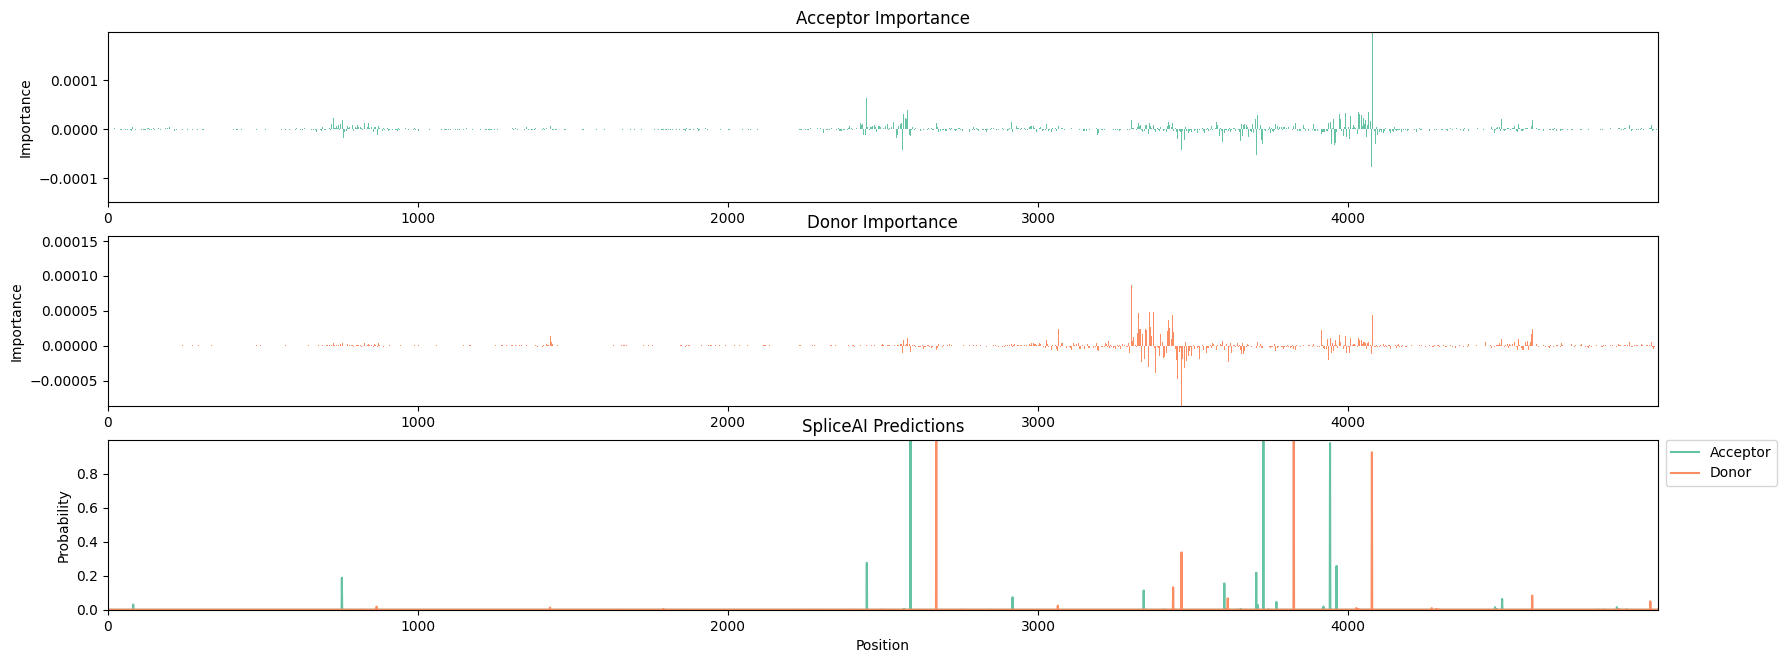

In [20]:
colors = sns.color_palette("Set2").as_hex()

plt.figure(figsize=(20, 7.5))
plt.tight_layout()

for i, name in enumerate(importances.keys()):
    plt.subplot(3, 1, i+1)
    plt.bar(range(len(importances[name][0][5000:10000])), importances[name][0][5000:10000], color=colors[i], label=name.capitalize())
    plt.margins(0)
    plt.ylim((np.min(importances[name][0]), np.max(importances[name][0].max())))
    plt.title(f"{name.capitalize()} Importance")
    plt.ylabel("Importance")

plt.subplot(3, 1, 3)
plt.plot(range(len(importances['acceptor'][1])), importances['acceptor'][1], color=colors[0], label='Acceptor')
plt.plot(range(len(importances['donor'][1])), importances['donor'][1], color=colors[1], label='Donor')
plt.title(f"SpliceAI Predictions")
plt.legend(loc="upper left", bbox_to_anchor=(1.005, 1), borderaxespad=0)
plt.margins(0)
plt.ylabel("Probability")
plt.xlabel("Position")
plt.show()